In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

data = pd.read_csv('data/radon.csv')
county_names = data.county.unique()
county_index = data.county_code.values

In [2]:
data[['county', 'log_radon', 'floor']].head()

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


In [4]:
indiv_traces = {}
for county_name in county_names:
    # Select subset of data in county
    c_data = data[data.county == county_name]
    c_data = c_data.reset_index(drop=True)
    
    c_log_radon = c_data.log_radon
    c_floor_measure = c_data.floor.values
    
    with pm.Model() as individual_model:
        a = pm.Normal('alpha', mu=0, sd=100 ** 2)
        b = pm.Normal('beta', mu=0, sd=100 ** 2)
        
        # Model error prior
        eps = pm.Uniform('eps', lower=0, upper=100)
        
        radon_est = a + b * c_floor_measure
        
        y_lik = pm.Normal('y_lik', mu=radon_est, sd=eps, observed=c_log_radon)
        
        step = pm.NUTS()
        trace = pm.sample(2000, step=step)
    
    indiv_traces[county_name] = trace

 99%|█████████▊| 2465/2500 [00:05<00:00, 491.11it/s]/home/thomas/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 2490/2500 [00:19<00:00, 106.22it/s]/home/thomas/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 12 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 99%|█████████▉| 2483/2500 [00:05<00:00, 614.10it/s]/home/thomas/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 2498/2500 [00:59<00:00, 17.43it/s]/home/thomas/anaconda3/lib/python

100%|█████████▉| 2490/2500 [00:47<00:00, 30.07it/s]/home/thomas/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 162 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 2496/2500 [01:00<00:00, 33.55it/s]/home/thomas/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 21 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 99%|█████████▉| 2476/2500 [00:21<00:00, 194.09it/s]/home/thomas/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 10 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 2496/2500 [00:18<00:00, 101.03it/s]/home/thomas/anaconda3/lib/pyth

In [6]:
with pm.Model() as hierarchical_model:
    mu_a = pm.Normal('mu_alpha', mu=0, sd=100 * 2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0, sd=100 * 2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)
    
    # Intercept vector, over counties.
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(county_names))
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=len(county_names))
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)
    
    radon_est = a[county_index] + b[county_index] * data.floor.values
    
    # Data likelihood
    y_lik = pm.Normal('y_lik', mu=radon_est, sd=eps, observed=data.log_radon)

In [7]:
with hierarchical_model:
    # Use ADVI initialisation
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=hierarchical_model.dict_to_array(sds) ** 2, is_cov=True)
    hierarchical_trace = pm.sample(5000, step, start=mu)

/home/thomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
  This is separate from the ipykernel package so we can avoid doing imports until
Average ELBO = -1,269.5:  40%|███▉      | 39696/100000 [00:08<00:12, 4698.01it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -1,111.3

100%|█████████▉| 5498/5500 [00:49<00:00, 111.14it/s]/home/thomas/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5500/5500 [00:49<00:00, 111.70it/s]


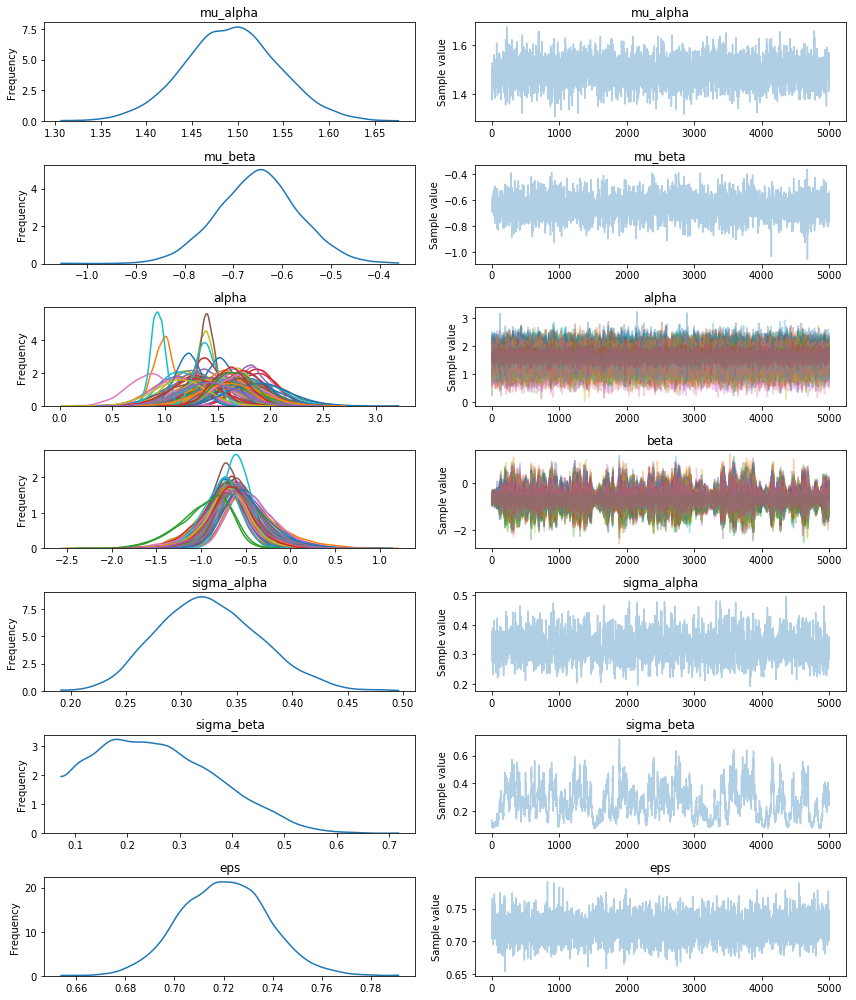

In [9]:
pm.traceplot(hierarchical_trace);

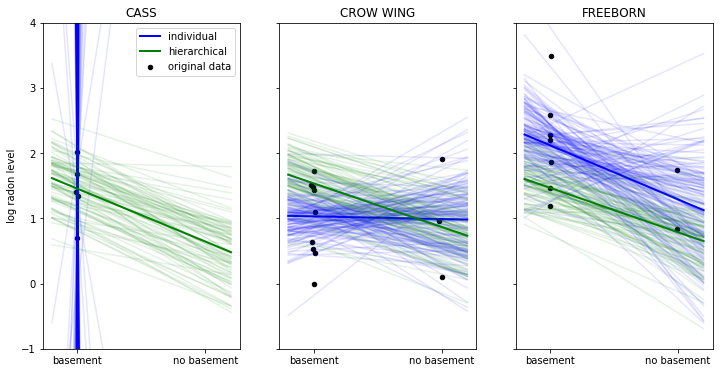

In [18]:
selection = ['CASS', 'CROW WING', 'FREEBORN']
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()

for i, c in enumerate(selection):
    c_data = data[data.county == c]
    c_data = c_data.reset_index(drop = True)
    z = list(c_data['county_code'])[0]

    xvals = np.linspace(-0.2, 1.2)
    
    for a_val, b_val in zip(indiv_traces[c]['alpha'][500::10], 
                            indiv_traces[c]['beta'][500::10]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'b', alpha=.1)
    axis[i].plot(xvals, 
                 indiv_traces[c]['alpha'][500::10].mean() 
                 + indiv_traces[c]['beta'][500::10].mean() * xvals, 
                 'b', 
                 alpha=1, lw=2., label='individual')

    for a_val, b_val in zip(hierarchical_trace['alpha'][500::10][z], 
                            hierarchical_trace['beta'][500::10][z]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'g', alpha=.1)
    axis[i].plot(xvals, hierarchical_trace['alpha'][500::10][z].mean() + hierarchical_trace['beta'][500::10][z].mean() * xvals, 
                 'g', alpha=1, lw=2., label='hierarchical')
    axis[i].scatter(c_data.floor + np.random.randn(len(c_data))*0.01, c_data.log_radon, 
                    alpha=1, color='k', marker='.', s=80, label='original data')
    axis[i].set_xticks([0,1])
    axis[i].set_xticklabels(['basement', 'no basement'])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i % 3:
        axis[i].legend()
        axis[i].set_ylabel('log radon level')

In [24]:
with hierarchical_model:
    print(pm.dic(hierarchical_trace))

2273.57912143


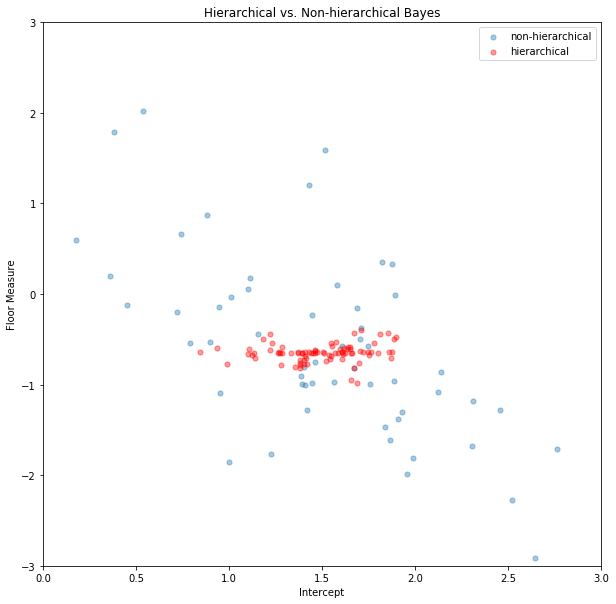

In [26]:
hier_a = hierarchical_trace['alpha'][500:].mean(axis=0)
hier_b = hierarchical_trace['beta'][500:].mean(axis=0)
indv_a = [indiv_traces[c]['alpha'][500:].mean() for c in county_names]
indv_b = [indiv_traces[c]['beta'][500:].mean() for c in county_names]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, xlabel='Intercept', ylabel='Floor Measure', 
                     title='Hierarchical vs. Non-hierarchical Bayes', 
                     xlim=(0, 3), ylim=(-3, 3))

ax.scatter(indv_a,indv_b, s=26, alpha=0.4, label = 'non-hierarchical')
ax.scatter(hier_a,hier_b, c='red', s=26, alpha=0.4, label = 'hierarchical')
# for i in range(len(indv_b)):  
#     ax.arrow(indv_a[i], indv_b[i], hier_a[i] - indv_a[i], hier_b[i] - indv_b[i], 
#              fc="k", ec="k", length_includes_head=True, alpha=0.4, head_width=.04)
ax.legend();